# Object Detection with SSD
### 在了解具體如何操作前，我們先來看看SSD效果

In [29]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
os.chdir("..")
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    print("using CUDA")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
from ssd import build_ssd

using CUDA


## 建立整個模型(SSD 300)
 

#### 這個預訓練權重是Train在VOC資料集上
#### 輸入影像是300*300，一共有20類+背景=21類
#### 先將模型架起

In [30]:
net = build_ssd('test', 300, 21)    # initialize SSD

c:\AL\Course\cupoy_電腦視覺與深度學習馬拉松\OpenCV_CVMarathon\homework\Day028\Object Detection 程式導讀\ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


## 將模型架構打印出來看

In [31]:
print(net)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(256, 

## 載入預訓練權重

In [32]:
os.chdir(os.path.join(os.getcwd(), "demo"))
net.load_weights('ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


## Load Image 
### Here we just load a sample image from the VOC07 dataset 

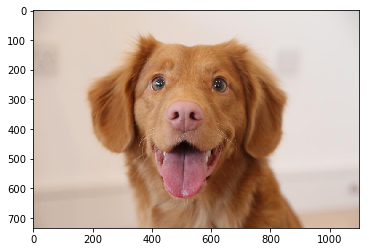

In [33]:
# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from PIL import Image, ImageFont, ImageDraw
image = Image.open('golden-retriever-puppy.jpg')
plt.imshow(image)
plt.show()
#image = image.resize((300,300), Image.ANTIALIAS)
image=np.asarray(image)
rgb_image=np.asarray(image)
# View the sampled input image before transform


## 輸入影像的預處理，與Training 時需要相同


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


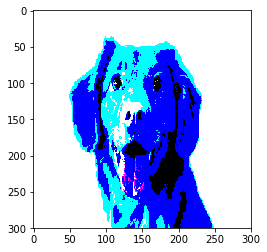

In [34]:
'''先Resize 成 300*300'''
x = cv2.resize(image, (300, 300)).astype(np.float32)
'''Vgg 16的預處理方式'''
x -= (104.0, 117.0, 123.0)
'''將type轉乘np.float32'''
x = x.astype(np.float32)
'''將RGB轉換為BGR'''
x = x[:, :, ::-1].copy()
plt.imshow(x)
plt.show()
'''轉換成torch 的 tensor，並且將 H,W,C 轉成 C,H,W'''
x = torch.from_numpy(x).permute(2, 0, 1)

## 將處理好之影像送入模型運算(Forward Pass)

In [35]:
'''要先用Variable包裝才能送給Pytorch模型'''
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
'''Forward Pass'''
y = net(xx)

In [36]:
'''Batch Size,類別數,top 200個框, 5=(delta x,delta y,delta h, delta w, confidence)'''
print(y.shape)

torch.Size([1, 21, 200, 5])


## 預測結果
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

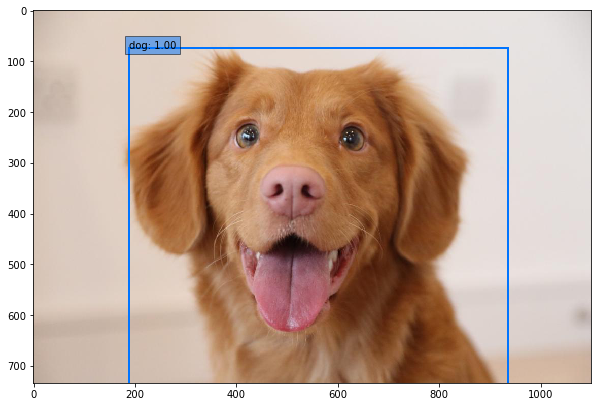

In [37]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
'''得到『寬、高、寬、高』的值，藉此將x1,y1,x2,y2回放為原本尺寸'''
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    '''信心程度>0.6的預測框才計算'''
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

## Real Time

In [38]:
from data import BaseTransform, VOC_CLASSES as labelmap

transform = BaseTransform(net.size, (104/256.0, 117/256.0, 123/256.0))

def detect(frame, net, transform):
    height, width = frame.shape[:2]
    frame_t = transform(frame)[0]
    # x = torch.from_numpy(frame_t).permute(2, 0, 1)    #from Al
    x = torch.from_numpy(frame_t).permute(2, 0, 1).cuda()   # from Al
    x = Variable(x.unsqueeze(0))
    y = net(x)
    detections = y.data
    scale = torch.Tensor([width, height, width, height])
    # detections = [batch, number of classes, number of occurence, (score, x0, Y0, x1, y1)]
    for i in range(detections.size(1)):
        j = 0
        while detections[0, i, j, 0] >= 0.6:
            # pt = (detections[0, i, j, 1:] * scale).numpy()    # from Al
            pt = (detections[0, i, j, 1:] * scale)      # from Al
            cv2.rectangle(frame, (int(pt[0]), int(pt[1])), (int(pt[2]), int(pt[3])), (255, 0, 0), 2)
            cv2.putText(frame, labelmap[i - 1], (int(pt[0]), int(pt[1])), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
            j += 1
    return frame
 

In [39]:
video_capture = cv2.VideoCapture(0)

while True:
    _, frame = video_capture.read()
    canvas = detect(frame, net, transform)
    cv2.imshow('Video', canvas)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

---